In [1]:
import numpy as np
from numpy import expand_dims
import pandas as pd
import json
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
import keras
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

In [2]:
with open('shipsnetd/shipsnet.json') as data_file:
    dataset = json.load(data_file)
shipsnet= pd.DataFrame(dataset)
shipsnet.head()

,data,labels,locations,scene_ids
0,"[82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...",1,"[-118.2254694333423, 33.73803725920789]",20180708_180909_0f47
1,"[76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...",1,"[-122.33222866289329, 37.7491755586813]",20170705_180816_103e
2,"[125, 127, 129, 130, 126, 125, 129, 133, 132, ...",1,"[-118.14283073363218, 33.736016066914175]",20180712_211331_0f06
3,"[102, 99, 113, 106, 96, 102, 105, 105, 103, 10...",1,"[-122.34784341495181, 37.76648707436548]",20170609_180756_103a
4,"[78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...",1,"[-122.34852408322172, 37.75878462398653]",20170515_180653_1007


In [3]:
shipsnet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   data       4000 non-null   object
 1   labels     4000 non-null   int64 
 2   locations  4000 non-null   object
 3   scene_ids  4000 non-null   object
dtypes: int64(1), object(3)
memory usage: 125.1+ KB


In [4]:
shipsnet = shipsnet[["data", "labels"]]
shipsnet.head()

,data,labels
0,"[82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...",1
1,"[76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...",1
2,"[125, 127, 129, 130, 126, 125, 129, 133, 132, ...",1
3,"[102, 99, 113, 106, 96, 102, 105, 105, 103, 10...",1
4,"[78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...",1


In [5]:
len(shipsnet["data"].iloc[0])

19200

In [6]:
ship_images = shipsnet["labels"].value_counts()[0]
no_ship_images = shipsnet["labels"].value_counts()[1]
print("Number of the ship_images :{}".format(ship_images),"\n")
print("Number of the no ship_images :{}".format(no_ship_images))

Number of the ship_images :3000 

Number of the no ship_images :1000


In [7]:
# Turning the json information into numpy array and then assign it as x and y variables
x = np.array(dataset['data']).astype('uint8')
y = np.array(dataset['labels']).astype('uint8')
x.shape

(4000, 19200)

In [8]:
x_reshaped = x.reshape([-1, 3, 80, 80])
x_reshaped.shape

(4000, 3, 80, 80)

In [9]:
x_reshaped = x.reshape([-1, 3, 80, 80]).transpose([0,2,3,1])
x_reshaped.shape

(4000, 80, 80, 3)

In [10]:
# here to_categorical  does converting array-like matrix into binary matrix
y_reshaped = to_categorical(y, num_classes=2)

y_reshaped.shape

(4000, 2)

In [11]:
# if value is 1 it represented as 0,1
# if value is 0 it represented as 1,0
y_reshaped

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

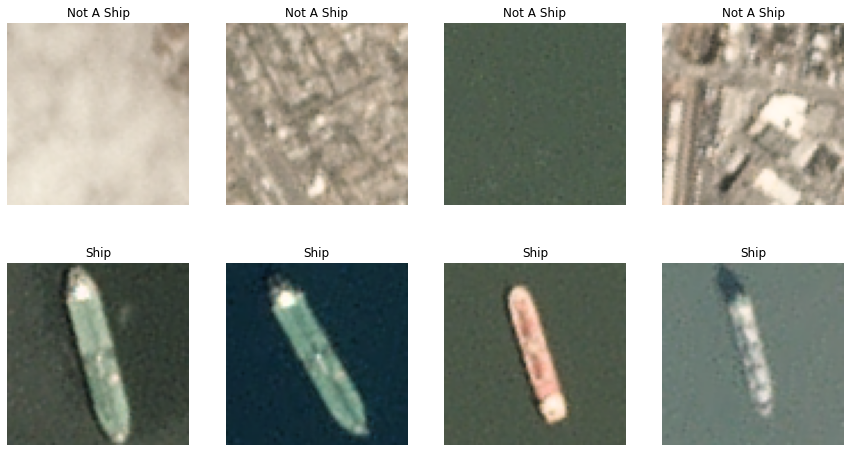

In [12]:
image_no_ship = x_reshaped[y==0]
image_ship = x_reshaped[y==1]

def plot(a,b):
    
    plt.figure(figsize=(15, 15))
    for i, k in enumerate(range(1,9)):
        if i < 4:
            plt.subplot(2,4,k)
            plt.title('Not A Ship')
            plt.imshow(image_no_ship[i+2])
            plt.axis("off")
        else:
            plt.subplot(2,4,k)
            plt.title('Ship')
            plt.imshow(image_ship[i+15])
            plt.axis("off")
            
    plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0.25)
    
#Implementation of the function 

plot(image_no_ship, image_ship)

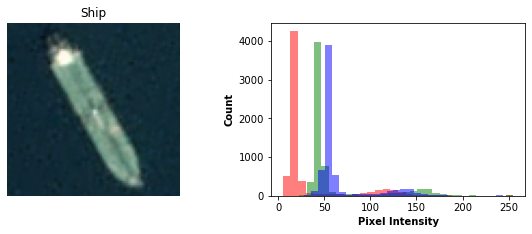

Minimum pixel value of this image: 5
Maximum pixel value of this image: 255


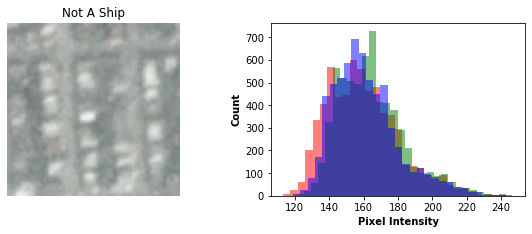

Minimum pixel value of this image: 113
Maximum pixel value of this image: 247


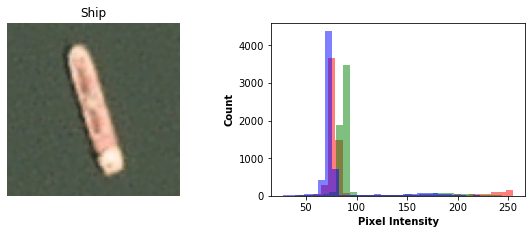

Minimum pixel value of this image: 27
Maximum pixel value of this image: 255


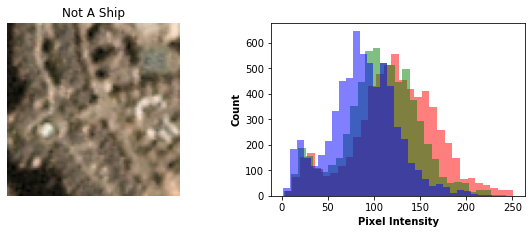

Minimum pixel value of this image: 1
Maximum pixel value of this image: 251


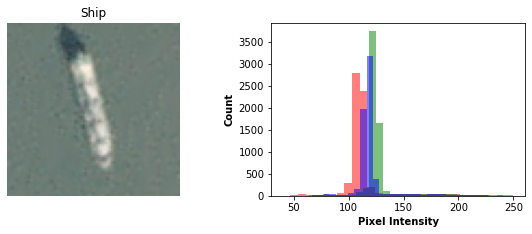

Minimum pixel value of this image: 40
Maximum pixel value of this image: 250


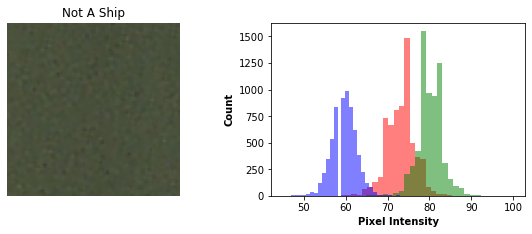

Minimum pixel value of this image: 45
Maximum pixel value of this image: 100


In [13]:
def plotHistogram(ship, not_ship):

    plt.figure(figsize = (10,7))
    plt.subplot(2,2,1)
    plt.imshow(ship)
    plt.axis('off')
    plt.title('Ship')
    histo = plt.subplot(2,2,2)
    histo.set_ylabel('Count', fontweight = "bold")
    histo.set_xlabel('Pixel Intensity', fontweight = "bold")
    n_bins = 30
    plt.hist(ship[:,:,0].flatten(), bins = n_bins, lw = 0, color = 'r', alpha = 0.5);
    plt.hist(ship[:,:,1].flatten(), bins = n_bins, lw = 0, color = 'g', alpha = 0.5);
    plt.hist(ship[:,:,2].flatten(), bins = n_bins, lw = 0, color = 'b', alpha = 0.5);
    plt.show()
    print("Minimum pixel value of this image: {}".format(ship.min()))
    print("Maximum pixel value of this image: {}".format(ship.max()))
    plt.figure(figsize = (10,7))
    plt.subplot(2,2,3)
    plt.imshow(not_ship)
    plt.axis('off')
    plt.title('Not A Ship')
    histo = plt.subplot(2,2,4)
    histo.set_ylabel('Count', fontweight = "bold")
    histo.set_xlabel('Pixel Intensity', fontweight = "bold")
    n_bins = 30
    plt.hist(not_ship[:,:,0].flatten(), bins = n_bins, lw = 0, color = 'r', alpha = 0.5);
    plt.hist(not_ship[:,:,1].flatten(), bins = n_bins, lw = 0, color = 'g', alpha = 0.5);
    plt.hist(not_ship[:,:,2].flatten(), bins = n_bins, lw = 0, color = 'b', alpha = 0.5);
    plt.show()
    print("Minimum pixel value of this image: {}".format(not_ship.min()))
    print("Maximum pixel value of this image: {}".format(not_ship.max()))
    
#Implementation of the function
for i in range (20,23):
    plotHistogram(x_reshaped[y==1][i], x_reshaped[y==0][i])

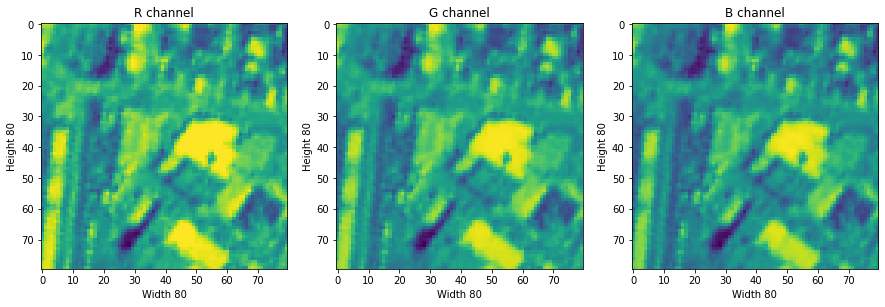

In [14]:
my_list = [(0, 'R channel'), (1, 'G channel'), (2, 'B channel')]

plt.figure(figsize = (15,15))

for i, k in my_list:
    plt.subplot(1,3,i+1)
    plt.title(k)
    plt.ylabel('Height {}'.format(x_reshaped[y==0][5].shape[0]))
    plt.xlabel('Width {}'.format(x_reshaped[y==0][5].shape[1]))
    plt.imshow(x_reshaped[y==0][5][ : , : , i])

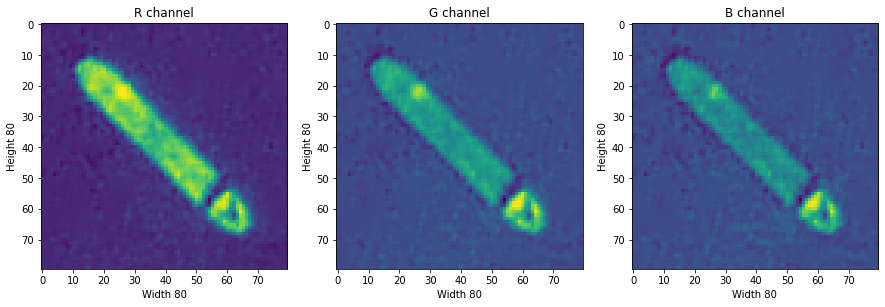

In [15]:
my_list = [(0, 'R channel'), (1, 'G channel'), (2, 'B channel')]

plt.figure(figsize = (15,15))

for i, k in my_list:
    plt.subplot(1,3,i+1)
    plt.title(k)
    plt.ylabel('Height {}'.format(x_reshaped[y==0][5].shape[0]))
    plt.xlabel('Width {}'.format(x_reshaped[y==0][5].shape[1]))
    plt.imshow(x_reshaped[y==1][5][ : , : , i])

In [16]:
x_reshaped = x_reshaped / 255
x_reshaped.shape

(4000, 80, 80, 3)

In [18]:
x_reshaped

array([[[[0.32156863, 0.36862745, 0.31372549],
         [0.34901961, 0.38823529, 0.3372549 ],
         [0.35686275, 0.39607843, 0.34901961],
         ...,
         [0.34901961, 0.4       , 0.3372549 ],
         [0.32941176, 0.37647059, 0.31764706],
         [0.3254902 , 0.37647059, 0.32941176]],

        [[0.34901961, 0.39215686, 0.3372549 ],
         [0.35686275, 0.4       , 0.34509804],
         [0.34901961, 0.39607843, 0.34901961],
         ...,
         [0.39607843, 0.45098039, 0.38039216],
         [0.34117647, 0.39215686, 0.32941176],
         [0.34117647, 0.38823529, 0.3372549 ]],

        [[0.35686275, 0.39607843, 0.34509804],
         [0.36470588, 0.40784314, 0.36078431],
         [0.3372549 , 0.38431373, 0.33333333],
         ...,
         [0.3254902 , 0.37647059, 0.31764706],
         [0.35294118, 0.4       , 0.34509804],
         [0.36078431, 0.4       , 0.34901961]],

        ...,

        [[0.34901961, 0.38431373, 0.34117647],
         [0.34509804, 0.38431373, 0.3372549 ]

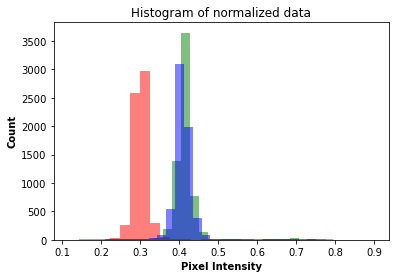

In [19]:
n_bins = 30
plt.hist(x_reshaped[y == 0][0][:,:,0].flatten(), bins = n_bins, lw = 0, color = 'r', alpha = 0.5);
plt.hist(x_reshaped[y == 0][0][:,:,1].flatten(), bins = n_bins, lw = 0, color = 'g', alpha = 0.5);
plt.hist(x_reshaped[y == 0][0][:,:,2].flatten(), bins = n_bins, lw = 0, color = 'b', alpha = 0.5);
plt.ylabel('Count', fontweight = "bold")
plt.xlabel('Pixel Intensity', fontweight = "bold")
plt.title("Histogram of normalized data")
plt.show()

In [20]:
x_train_1, x_test, y_train_1, y_test = train_test_split(x_reshaped, y_reshaped,
                                                        test_size = 0.20, random_state = 42)

# this set is for validation
x_train, x_val, y_train, y_val = train_test_split(x_train_1, y_train_1, test_size = 0.25, random_state = 42)


print("x_train shape",x_train.shape)
print("x_test shape",x_test.shape)
print("y_train shape",y_train.shape)
print("y_test shape",y_test.shape)
print("x_val shape",x_val.shape)
print("y_val shape",y_val.shape)

x_train shape (2400, 80, 80, 3)
x_test shape (800, 80, 80, 3)
y_train shape (2400, 2)
y_test shape (800, 2)
x_val shape (800, 80, 80, 3)
y_val shape (800, 2)


In [21]:
from keras import callbacks
# creating a neural network
model = Sequential()
# we are adding all the layers

# we are adding input layer
model.add(Flatten(input_shape=[80, 80, 3]))
# we are adding hidden layer relu has activation function
# genearal guide lines forhidden layer to add relu has activation function
# here 200 are neurons
# output layer has 1 and 0 so  the activation is sigmoid
# here 2 because getting output as 1 or 0

model.add(Dense(200, activation='relu'))
# another layer
model.add(Dense(150, activation='relu'))


model.add(Dense(2, activation='sigmoid'))

# we are compiling our model
# using adam as optimizer
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
# if model is stopped improving then we are stopping it
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 10, 
                                        restore_best_weights = True)
# We are running as 100 epochs
# epoch means indicates the number of passes of the entire training dataset the machine leaning algorithm as completed

#Actually our model does't see validation set and isn't anyway trained on it
# actually we are architect and master of hyperparameters tune the odel according to this data
# therefor it indirectly influences your model because it directly influences your decisions
history = model.fit(x_train, y_train, epochs = 100, validation_data=(x_val, y_val), callbacks = [earlystopping])

Epoch 1/100
75/75 [==============================] - 6s 24ms/step - loss: 1.6446 - accuracy: 0.7446 - val_loss: 0.3566 - val_accuracy: 0.8587
Epoch 2/100
75/75 [==============================] - 2s 23ms/step - loss: 0.3584 - accuracy: 0.8521 - val_loss: 0.4379 - val_accuracy: 0.8313
Epoch 3/100
75/75 [==============================] - 1s 14ms/step - loss: 0.3981 - accuracy: 0.8521 - val_loss: 0.3555 - val_accuracy: 0.8525
Epoch 4/100
75/75 [==============================] - 1s 13ms/step - loss: 0.3921 - accuracy: 0.8537 - val_loss: 0.2791 - val_accuracy: 0.8900
Epoch 5/100
75/75 [==============================] - 1s 13ms/step - loss: 0.3043 - accuracy: 0.8783 - val_loss: 0.3194 - val_accuracy: 0.8838
Epoch 6/100
75/75 [==============================] - 1s 13ms/step - loss: 0.3081 - accuracy: 0.8821 - val_loss: 0.7463 - val_accuracy: 0.8150
Epoch 7/100
75/75 [==============================] - 1s 12ms/step - loss: 0.2918 - accuracy: 0.8771 - val_loss: 0.2859 - val_accuracy: 0.8838
Epoch 

In [22]:
# we are evaluating on x_test and y_test
# we got y_test value accuarcy as 91.87%
model.evaluate(x_test, y_test)

25/25 [==============================] - 0s 7ms/step - loss: 0.1820 - accuracy: 0.9262


[0.18202868103981018, 0.9262499809265137]

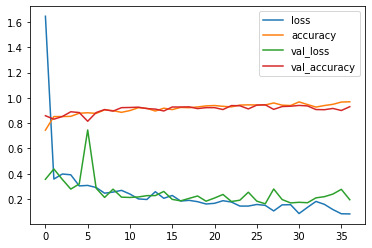

In [23]:
# we draw a chart for loss, accuracy, value_loss and value_accuracy
pd.DataFrame(history.history).plot();

In [24]:
# we are testing our model here with test set
prediction = model.predict(x_test)
pd.Series(prediction[0][1], index=[ "Ship"])
# prediction

25/25 [==============================] - 0s 4ms/step


Ship    0.670844
dtype: float32

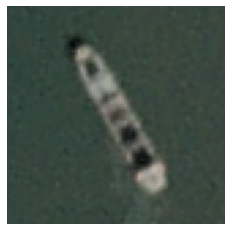

In [25]:
plt.imshow(x_test[0])
plt.axis("off")
plt.show()

In [26]:
predicted_data = pd.DataFrame(prediction, columns=["Not a ship", "Ship"])
predicted_data.head(3)
predicted_data["Ship"].iloc[0:3]

0    0.670844
1    0.052337
2    0.849126
Name: Ship, dtype: float32

In [27]:
y_test_data = pd.DataFrame(y_test, columns=["Not A Ship", "Ship"])
y_test_data.head(10)

,Not A Ship,Ship
0,0.0,1.0
1,1.0,0.0
2,0.0,1.0
3,1.0,0.0
4,1.0,0.0
5,0.0,1.0
6,1.0,0.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


In [28]:
predicted_data['There is a Ship'] = y_test[:, 1]
predicted_data.pop("Not a ship")
predicted_data.head()

,Ship,There is a Ship
0,0.670844,1.0
1,0.052337,0.0
2,0.849126,1.0
3,0.815155,0.0
4,0.027208,0.0


In [29]:
predicted_data["Difference"] = predicted_data["Ship"] - predicted_data["There is a Ship"]
predicted_data

,Ship,There is a Ship,Difference
0,0.670844,1.0,-0.329156
1,0.052337,0.0,0.052337
2,0.849126,1.0,-0.150874
3,0.815155,0.0,0.815155
4,0.027208,0.0,0.027208
...,...,...,...
795,0.390171,0.0,0.390171
796,0.678455,1.0,-0.321545
797,0.135065,0.0,0.135065
798,0.030722,0.0,0.030722


In [30]:
indexes = predicted_data.sort_values('Difference', ascending = False).head(4).index.to_list()

def plotHistogram(image_index):

    plt.figure(figsize = (10,7))
    plt.subplot(2,2,1)
    plt.imshow(x_test[image_index])
    plt.axis('off')
    plt.title('There is no ship. But predicted as a ship.')
    histo = plt.subplot(2,2,2)
    histo.set_ylabel('Count', fontweight = "bold")
    histo.set_xlabel('Pixel Intensity', fontweight = "bold")
    n_bins = 30
    plt.hist(x_test[image_index][:,:,0].flatten(), bins = n_bins, lw = 0, color = 'r', alpha = 0.5);
    plt.hist(x_test[image_index][:,:,1].flatten(), bins = n_bins, lw = 0, color = 'g', alpha = 0.5);
    plt.hist(x_test[image_index][:,:,2].flatten(), bins = n_bins, lw = 0, color = 'b', alpha = 0.5);
    plt.show()

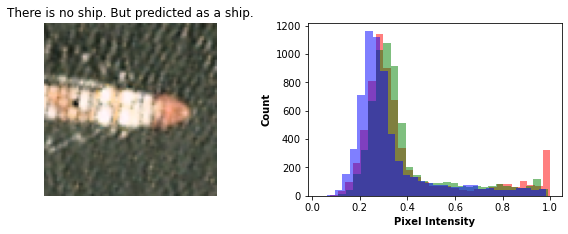

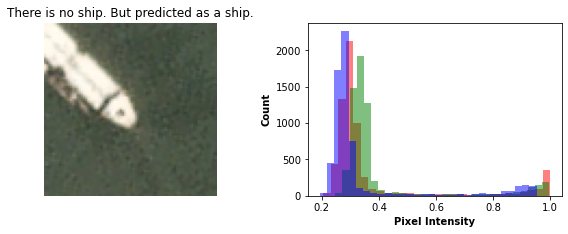

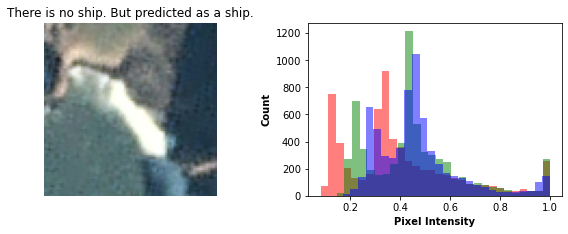

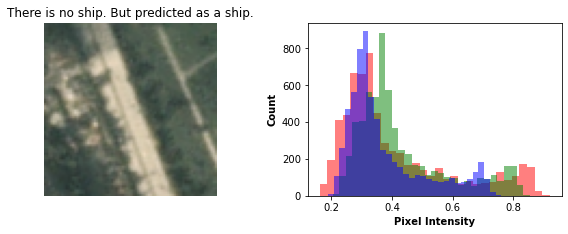

In [31]:
for i in indexes:
    plotHistogram(i)

In [32]:
predicted_data.sort_values('Difference', ascending=True).head(10)

,Ship,There is a Ship,Difference
537,0.027476,1.0,-0.972524
578,0.053853,1.0,-0.946147
365,0.141867,1.0,-0.858133
247,0.212462,1.0,-0.787538
518,0.249947,1.0,-0.750053
363,0.269465,1.0,-0.730535
47,0.269761,1.0,-0.730239
322,0.279346,1.0,-0.720654
100,0.298559,1.0,-0.701441
454,0.310931,1.0,-0.689069


In [33]:
indexes = predicted_data.sort_values('Difference', ascending = True).head(4).index.to_list()

def plotHistogram(image_index):

    plt.figure(figsize = (10,7))
    plt.subplot(2,2,1)
    plt.imshow(x_test[image_index])
    plt.axis('off')
    plt.title('There is a ship. But predicted as not a ship.')
    histo = plt.subplot(2,2,2)
    histo.set_ylabel('Count', fontweight = "bold")
    histo.set_xlabel('Pixel Intensity', fontweight = "bold")
    n_bins = 30
    plt.hist(x_test[image_index][:,:,0].flatten(), bins = n_bins, lw = 0, color = 'r', alpha = 0.5);
    plt.hist(x_test[image_index][:,:,1].flatten(), bins = n_bins, lw = 0, color = 'g', alpha = 0.5);
    plt.hist(x_test[image_index][:,:,2].flatten(), bins = n_bins, lw = 0, color = 'b', alpha = 0.5);
    plt.show()

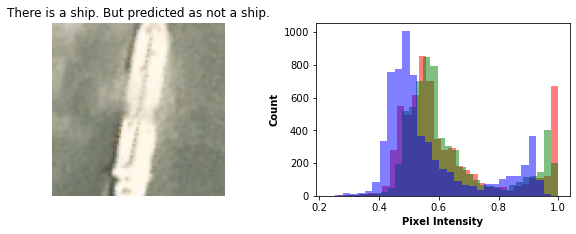

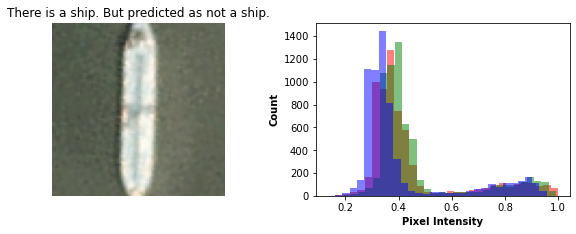

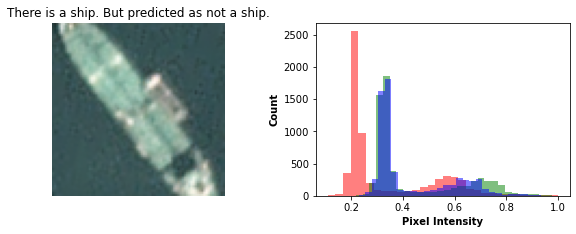

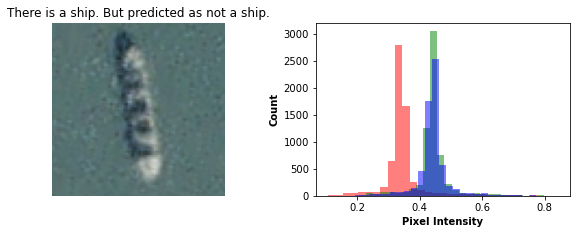

In [34]:
for i in indexes:
    plotHistogram(i)


Test Accuracy Score :  0.92625 



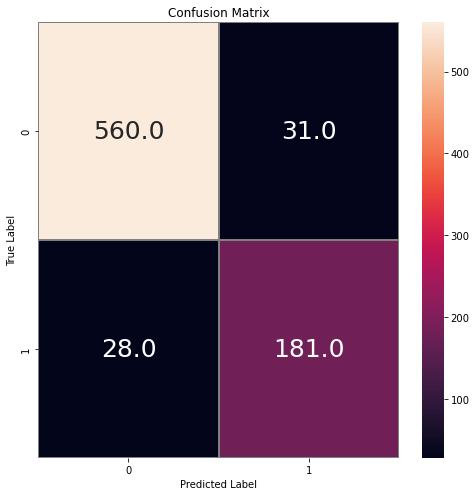

In [35]:
from sklearn import metrics
import seaborn as sns
# Convert predictions classes to one hot vectors 
Y_pred = np.argmax(prediction,axis = 1)
Y_true = np.argmax(y_test,axis = 1)
# print(Y_true)
# print(Y_pred)

confusion_mtx = confusion_matrix(Y_true, Y_pred)

print("\n""Test Accuracy Score : ",metrics.accuracy_score(Y_true, Y_pred),"\n")

# Plot the confusion matrix
f,ax = plt.subplots(figsize=(7, 7))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,linecolor="gray", fmt= '.1f',ax=ax, annot_kws={'size':25})
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()

plt.show()